In [15]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
labels_to_ids = {
    "Educational": 0,
    "Entertainment": 1,
}

num_labels = len(labels_to_ids)

In [17]:
import pandas as pd

labeled_mapped_csv_path = Path.cwd() / "labeled_mapped.csv"

# Load data from CSV file
df = pd.read_csv(labeled_mapped_csv_path)

# Read header for column names
column_names = df.columns.tolist()

print(column_names)

# Split data into labels and titles
all_labels = df["label"].tolist()
all_titles = df["title"].tolist()

# Print first 5 all_labels and all_titles
print(all_labels[:10])

# Convert all_labels to integers
all_labels = np.vectorize(labels_to_ids.get)(all_labels)
print(all_labels[:10])

# all_labels = to_categorical(all_labels)
# print(all_labels[:10])

print(all_titles[:10])
print("Lenght of dataset: ", len(all_labels))

['label', 'title', 'path']
['Entertainment', 'Entertainment', 'Educational', 'Educational', 'Entertainment', 'Entertainment', 'Educational', 'Entertainment', 'Educational', 'Entertainment']
[1 1 0 0 1 1 0 1 0 1]
['SIDEMEN GUESS THE LINK OFFENSIVE EDITION by MoreSidemen', 'Our Most Demonic Experience  Zak Bagans Haunted Museum by Sam and Colby', 'How SpaceX and Boeing will get Astronauts to the ISS by EverydayAstronaut', "'TIRED OF IT' Voters sound off after latest attacks on Trump by FoxNews", "Can We Predict An Outbreak's Future - Modeling Crash Course Outbreak Science #9 by crashcourse", 'Chloe vs. Kendall Rematch (S4, E4)  Full Episode  Dance Moms by Dance Moms', 'The method that can prove almost anything - James A. Smith by TEDEd', 'Biden welcomes Houston Astros to the White House by NBCNews', 'Can You Solve This Shadow Illusion by Veritasium', 'TURNING MY BACKYARD INTO A WINTER WONDERLAND! snow in LA! by JamesCharles']
Lenght of dataset:  114


In [18]:
tokenizer = BertTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
model = TFBertForSequenceClassification.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', num_labels = num_labels, from_pt = True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['fit_denses.3.bias', 'fit_denses.2.weight', 'fit_denses.4.weight', 'fit_denses.3.weight', 'fit_denses.2.bias', 'fit_denses.0.weight', 'fit_denses.0.bias', 'fit_denses.1.bias', 'fit_denses.4.bias', 'fit_denses.1.weight']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classif

In [19]:
all_encodings = tokenizer(all_titles, truncation=True, padding=True, max_length=128)

print(all_encodings.keys())
print(all_encodings['input_ids'][0])
print(all_encodings['attention_mask'][0])

    
all_dataset = tf.data.Dataset.from_tensor_slices((
    dict(all_encodings),
    all_labels
))


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
[101, 2217, 3549, 3984, 1996, 4957, 5805, 3179, 2011, 2062, 7363, 3549, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [20]:
all_dataset_len = len(all_dataset)
print("All dataset length: ", all_dataset_len)

all_dataset = all_dataset.shuffle(buffer_size=all_dataset_len, reshuffle_each_iteration=False)

test_size = int(0.2 * all_dataset_len) # 20% of the data as test
valid_size = int(0.16 * all_dataset_len) # 20% of the data as validation
train_size = int(0.64 * all_dataset_len) # 60% of the data as train

test_dataset = all_dataset.take(test_size)
val_dataset = all_dataset.skip(test_size).take(valid_size) 
train_dataset = all_dataset.skip(test_size + valid_size) 

print("Train dataset length: ", len(list(train_dataset)))
print("Validation dataset length: ", len(list(val_dataset)))
print("Test dataset length: ", len(list(test_dataset)))

All dataset length:  114
Train dataset length:  74
Validation dataset length:  18
Test dataset length:  22


In [21]:
model.summary()


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  14350248  
                                                                 
 dropout_41 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  626       
                                                                 
Total params: 14350874 (54.74 MB)
Trainable params: 14350874 (54.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
model = TFBertForSequenceClassification.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', num_labels = num_labels, from_pt = True)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(train_dataset.batch(2), epochs=100, batch_size=2, validation_data=val_dataset.batch(2))


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['fit_denses.3.bias', 'fit_denses.2.weight', 'fit_denses.4.weight', 'fit_denses.3.weight', 'fit_denses.2.bias', 'fit_denses.0.weight', 'fit_denses.0.bias', 'fit_denses.1.bias', 'fit_denses.4.bias', 'fit_denses.1.weight']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classif

Epoch 1/100


2023-08-12 00:50:39.514631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5541

2023-08-12 00:50:45.913604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 11s 138ms/step - loss: 0.6920 - accuracy: 0.5541 - val_loss: 0.7019 - val_accuracy: 0.3333
Epoch 2/100
37/37 [==============================] - 3s 89ms/step - loss: 0.6878 - accuracy: 0.5811 - val_loss: 0.7068 - val_accuracy: 0.3333
Epoch 3/100
37/37 [==============================] - 3s 87ms/step - loss: 0.6838 - accuracy: 0.5811 - val_loss: 0.7125 - val_accuracy: 0.3333
Epoch 4/100
37/37 [==============================] - 3s 86ms/step - loss: 0.6774 - accuracy: 0.5811 - val_loss: 0.7181 - val_accuracy: 0.3333
Epoch 5/100
37/37 [==============================] - 3s 86ms/step - loss: 0.6664 - accuracy: 0.5811 - val_loss: 0.7199 - val_accuracy: 0.3333
Epoch 6/100
37/37 [==============================] - 3s 89ms/step - loss: 0.6470 - accuracy: 0.6351 - val_loss: 0.7124 - val_accuracy: 0.3333
Epoch 7/100
37/37 [==============================] - 3s 86ms/step - loss: 0.6130 - accuracy: 0.7297 - val_loss: 0.6852 - val_accuracy: 0.4444
Epoch 8/100
37/3

KeyboardInterrupt: 

In [23]:
model.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  14350248  
                                                                 
 dropout_55 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  626       
                                                                 
Total params: 14350874 (54.74 MB)
Trainable params: 14350874 (54.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


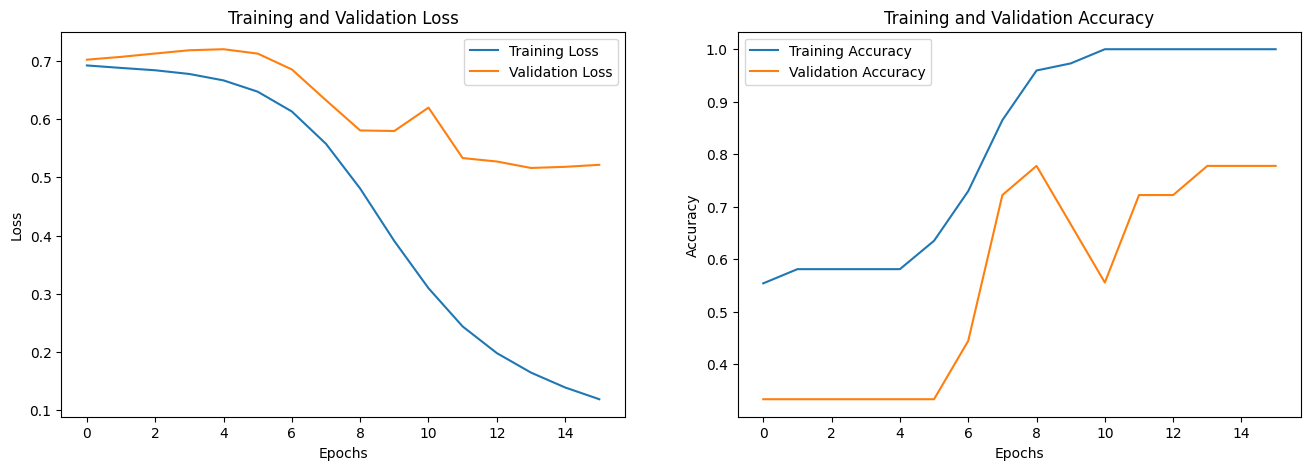

In [24]:
# Visualize the training process
history = model.history

figure, axis = plt.subplots(1, 2, figsize=(16, 5))
axis[0].plot(history.history['loss'], label='Training Loss')
axis[0].plot(history.history['val_loss'], label='Validation Loss')
axis[0].set_title('Training and Validation Loss')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].legend()

axis[1].plot(history.history['accuracy'], label='Training Accuracy')
axis[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axis[1].set_title('Training and Validation Accuracy')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')
axis[1].legend()

plt.show()

In [27]:
# Test the model
print('Evaluate on test data')
results = model.evaluate(test_dataset.batch(2), batch_size=2)

Evaluate on test data
11/11 [==============================] - 0s 36ms/step - loss: 0.4549 - accuracy: 0.7727
